In [10]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
data = pd.read_csv('train_set_100.csv', encoding='utf-8')
data['mahkemes'] = data['mahkemes'].values.astype(str)
data['ictihats'] = data['ictihats'].values.astype(str)
for i,mahkeme in enumerate(data['mahkemes']):
    data['mahkemes'][i] = mahkeme.replace(" ", "_")
print(data.mahkemes.unique())
data['labels'] = pd.factorize(data.mahkemes)[0]

['undefined' 'asliye_hukuk_mahkemesi' 'bolge_adliye_mahkemesi'
 'ticaret_mahkemesi' 'other' 'is_mahkemesi' 'asliye_ceza_mahkemesi'
 'ceza_dairesi' 'cocuk_mahkemesi' 'agir_ceza_mahkemesi']


In [11]:
#data.head()
#data.iloc[:, 1] = data.iloc[:, 1].apply(lambda x: '__label__' + x)

In [12]:
#data split for train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [13]:
train.head()

,ictihats,mahkemes,labels
0,taraf 6831 2b maddes orma beyan hanes şerh kay...,asliye_hukuk_mahkemesi,1
1,taraf çocuk kor istek ilişk başkan kurul 10012...,other,4
2,hük oe suç mahkumiyet çocuk nitelikli cinsel s...,agir_ceza_mahkemesi,9
3,hük mahkumiyet görüşülüp düşünül yüklene suç y...,asliye_ceza_mahkemesi,6
4,2709 141 6100 31 taraf görüle dav sonuç verile...,undefined,0


In [14]:
test.head()

,ictihats,mahkemes,labels
0,hük cinsel taciz suç mahkumiyet tehdit suç kar...,asliye_ceza_mahkemesi,6
1,hük beraat nitelikli resmi belge düzenlenme be...,agir_ceza_mahkemesi,9
2,tarih bölge adli mahkeme verile müddet temyize...,bolge_adliye_mahkemesi,2
3,taraf tazminat mahkemeç sonuç kabul verile hük...,asliye_hukuk_mahkemesi,1
4,taraf muhakemes mahalli mahkemeç verile tarih ...,cocuk_mahkemesi,8


In [15]:
#Data prepare for fasttext format for train
train["label_format"]=0
train["label_format_without_ictihats"]=0
for i in range(len(train)):
    train.label_format[i]="__label__"+str(train.mahkemes[i])+" "+str(train.ictihats[i])
    train.label_format_without_ictihats[i]="__label__"+str(train.mahkemes[i])

C:\Users\anlsn\AppData\Local\Temp\ipykernel_14008\3046627546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label_format[i]="__label__"+str(train.mahkemes[i])+" "+str(train.ictihats[i])
C:\Users\anlsn\AppData\Local\Temp\ipykernel_14008\3046627546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label_format_without_ictihats[i]="__label__"+str(train.mahkemes[i])


In [16]:
#Data prepare for fasttext format for test
test["label_format"]=0
test["label_format_without_ictihats"]=0
for i in range(len(test)):
    test.label_format[i]="__label__"+str(test.mahkemes[i])+" "+str(test.ictihats[i])
    test.label_format_without_ictihats[i]="__label__"+str(test.mahkemes[i])

C:\Users\anlsn\AppData\Local\Temp\ipykernel_14008\708011051.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.label_format[i]="__label__"+str(test.mahkemes[i])+" "+str(test.ictihats[i])
C:\Users\anlsn\AppData\Local\Temp\ipykernel_14008\708011051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.label_format_without_ictihats[i]="__label__"+str(test.mahkemes[i])


In [17]:
train.label_format.to_csv('fasttext_train.txt',index=None,header=None)
test.label_format.to_csv('fasttext_test.txt',index=None,header=None)


In [18]:
import fasttext
#train classifier model
model = fasttext.train_supervised('fasttext_train.txt',epoch=100,lr=0.05,label_prefix='__label__',dim=300)
# model.save_model('model.bin')


In [19]:
model.test('fasttext_test.txt')
# print(model_test)
# precision = model_test[1]
# recall = model_test[2]
# f1_score = (2*(precision*recall))/(precision + recall)
# result = model.test('fasttext_train.txt')
# validation = model.test('fasttext_test.txt')
# text_line =  "accuracy:" + str(result[1])  + "\nvalidation:" + str(validation[1]) + '\n' 
# print ('Precision:', precision)
# print ('F1 score:', f1_score)
# print ('Recall:', recall)
# print(text_line)



(5571, 0.8804523424878837, 0.8804523424878837)

In [23]:

y_pred = test.iloc[:, 0].apply(lambda x: model.predict(x)[0][0])
#print(y_pred.unique())
y_test = test.label_format_without_ictihats
#print(y_test.unique())

cf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(cf_matrix)

                                 precision    recall  f1-score   support

   __label__agir_ceza_mahkemesi       0.82      0.73      0.78       365
 __label__asliye_ceza_mahkemesi       0.90      0.93      0.92      1950
__label__asliye_hukuk_mahkemesi       0.79      0.82      0.81       375
__label__bolge_adliye_mahkemesi       0.93      0.93      0.93       494
          __label__ceza_dairesi       0.96      0.92      0.94       232
       __label__cocuk_mahkemesi       0.56      0.46      0.50       172
          __label__is_mahkemesi       0.92      0.96      0.94       255
                 __label__other       0.74      0.65      0.69       292
     __label__ticaret_mahkemesi       0.66      0.57      0.61        69
             __label__undefined       0.93      0.94      0.93      1367

                       accuracy                           0.88      5571
                      macro avg       0.82      0.79      0.80      5571
                   weighted avg       0.88      0

In [24]:
model.predict('bicaklamak')


(('__label__undefined',), array([1.00001001]))

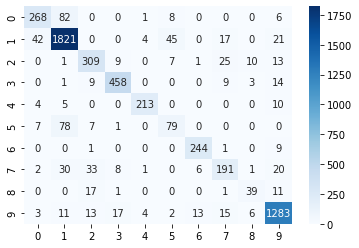

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')